In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import load_model,Model
from PIL import Image
import IPython.display as display
import time

In [12]:
image_path=input(r'Enter path of Image for noise : ')

Enter path of Image for noise : C://Users//admin//Downloads//image_thumb12.png


In [13]:
def load_image(image_path,max_dim=512):
    img=Image.open(image_path)
    img=img.convert("RGB")
    img.thumbnail([max_dim,max_dim])
    img=np.array(img,dtype=np.uint8)
    img=np.expand_dims(img,axis=0)
    return img

In [14]:
def deprocess_inception_image(img):
    img = 255*(img+1.0)/2.0
    return np.array(img, np.uint8)

In [15]:
def array_to_img(array,deprocessing=False):
    if deprocessing:
        array=deprocess_inception_image(array)
    if np.ndim(array)>3:
        assert array.shape[0]==1
        array=array[0]
    return Image.fromarray(array)

In [16]:
def show_image(img):
    image=array_to_img(img)
    display.display(image)

(1, 375, 512, 3)


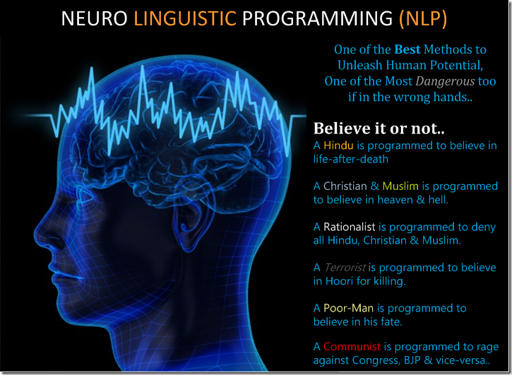

In [17]:
input_image=load_image(image_path,max_dim=512)
print(input_image.shape)
show_image(input_image)

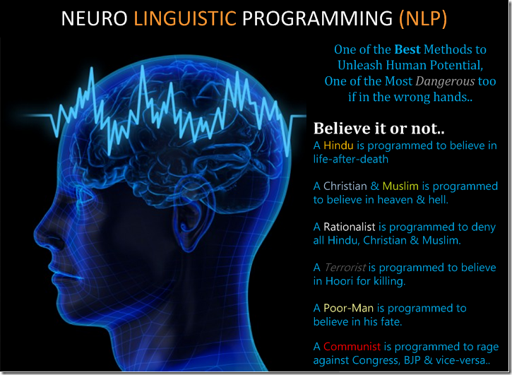

In [18]:
preprocessed_image=inception_v3.preprocess_input(input_image)
show_image(deprocess_inception_image(preprocessed_image))

In [19]:
def deep_dream_model(model,layer_names):
    model.trainable=False
    outputs=[model.get_layer(name).output for name in layer_names]
    new_model=Model(inputs=model.input,outputs=outputs)
    return new_model

In [20]:
inception=inception_v3.InceptionV3(weights="imagenet",include_top=False)
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [21]:
layers_contributions=['mixed3', 'mixed5']

In [22]:
dream_model=deep_dream_model(inception,layers_contributions)

In [23]:
deep_outputs=dream_model(preprocessed_image)
for layer_name,outputs in zip(layers_contributions,deep_outputs):
    print(layer_name)
    print(outputs.shape)
    print(outputs.numpy().mean())

mixed3
(1, 21, 30, 768)
0.41392064
mixed5
(1, 21, 30, 768)
0.17952113


In [24]:
model_output= lambda model,inputs:model(inputs)

In [25]:
def get_loss(activations):
    loss=[]
    for activation in activations:
        loss.append(tf.math.reduce_mean(activation))
    return tf.reduce_sum(loss)

In [26]:
def get_loss_and_gradient(model,inputs,total_variation_weight=0):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        activations=model_output(model,inputs)
        loss=get_loss(activations)
        loss=loss+total_variation_weight*tf.image.total_variation(inputs)
    grads=tape.gradient(loss,inputs)
    grads /= tf.math.reduce_std(grads) + 1e-8 
    return loss,grads

In [27]:
def run_gradient_ascent(model,inputs,epochs=1,steps_per_epoch=1,weight=0.01,total_variation_weight=0):
    img = tf.convert_to_tensor(inputs)
    start=time.time()
    for i in range(epochs):
        print(f"epoch: {i+1}",end=' ')
        for j in range(steps_per_epoch):
            loss,grads=get_loss_and_gradient(model,img,total_variation_weight)
            img = img + grads*weight
            img = tf.clip_by_value(img, -1.0, 1.0)
            print('=',end='')
        print("\n")
    end=time.time()
    print(f"Time elapsed: {end-start:1f}sec")
    return img.numpy()

In [28]:
image_array=run_gradient_ascent(dream_model,preprocessed_image,epochs=2,steps_per_epoch=100,weight=0.01)

epoch: 1 ====================================================================================================

epoch: 2 ====================================================================================================

Time elapsed: 350.473473sec


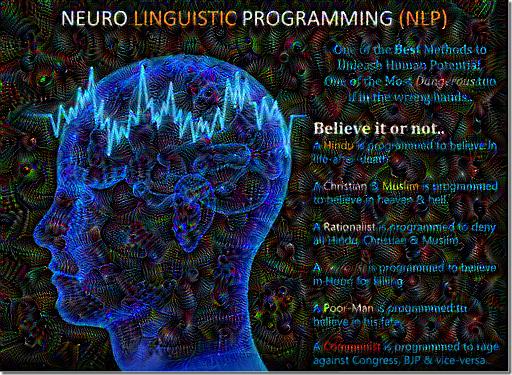

In [29]:
show_image(deprocess_inception_image(image_array))
resultant_image=array_to_img(image_array,True)
resultant_image.save("deep_dream_simple.jpg")

In [30]:
def random_image_tiling(img, maxdim):
    shift = tf.random.uniform(shape=[2], minval=-maxdim, maxval=maxdim, dtype=tf.int32)
    shift_r,shift_d=shift
    img_rolled = tf.roll(img, shift=[shift_r,shift_d], axis=[1,0])
    return shift_r, shift_d, img_rolled

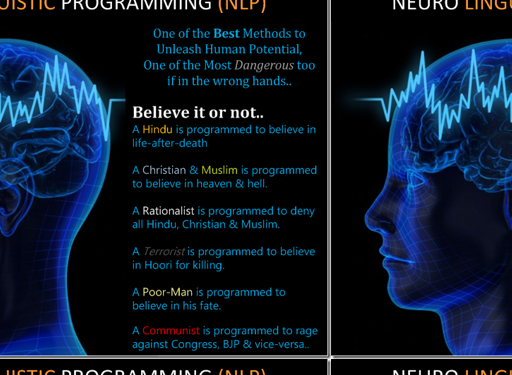

In [31]:
shift_r,shift_d,img_tiled=random_image_tiling(input_image[0], 512)
show_image(img_tiled.numpy())

In [32]:
def get_loss_and_grads_with_tiling(model,inputs,tile_size=512,total_variation_weight=0.004):
    shift_r,shift_d,rolled_image=random_image_tiling(inputs[0],tile_size)
    grads=tf.zeros_like(rolled_image)
    # create a tensor from 0 to rolled_image width with step of tile size
    x_range = tf.range(0, rolled_image.shape[0], tile_size)[:-1]
    # check if x_range is not empty
    if not tf.cast(len(x_range), bool):
        x_range= tf.constant([0])
    # create a tensor from 0 to rolled_image height with step of tile size
    y_range = tf.range(0, rolled_image.shape[1], tile_size)[:-1] 
    # check if y_range is not empty
    if not tf.cast(len(y_range), bool):
        y_range=tf.constant([0])
    for x in x_range:
        for y in y_range:
            with tf.GradientTape() as tape:
                tape.watch(rolled_image)
                # here we create tile from rolled image of size=tile_size
                image_tile= tf.expand_dims(rolled_image[x:x+tile_size, y:y+tile_size],axis=0)
                activations=model_output(model,image_tile)
                loss=get_loss(activations)
                loss=loss+total_variation_weight*tf.image.total_variation(image_tile) 
            grads=grads+tape.gradient(loss,rolled_image)
    grads = tf.roll(grads, shift=[-shift_r,-shift_d], axis=[1,0]) #reverse shifting of rolled image
    grads /= tf.math.reduce_std(grads) + 1e-8
    return loss,grads

In [33]:
def run_gradient_ascent_with_octave_tiling(model,inputs,steps_per_octave=100,num_octaves=2,octave_size=1.3,tile_size=512,weight=0.01,total_variation_weight=0.0004):
    img=tf.convert_to_tensor(inputs)
    weight=tf.convert_to_tensor(weight)
    assert len(inputs.shape)<=4 or len(inputs.shape)>=3
    if len(inputs.shape)==3:
        base_shape=img.shape[:-1]
    base_shape=img.shape[1:-1]
    start=time.time()
    for n in range(-num_octaves,num_octaves+1):
        print(f'Processing Octave: {n+num_octaves+1}')
        new_shape=tuple([int(dim*(octave_size**n)) for dim in base_shape])
        img=tf.image.resize(img,new_shape)
        for step in range(steps_per_octave):
            print('=',end='')
            loss,grads=get_loss_and_grads_with_tiling(model,img,tile_size,total_variation_weight)
            img = img + grads*weight
            img = tf.clip_by_value(img, -1.0, 1.0)
        print("\n")
    end=time.time()
    print(f"Time elapsed: {end-start:.1f} sec")
    return tf.image.resize(img, base_shape).numpy()

In [34]:
image_array=run_gradient_ascent_with_octave_tiling(dream_model,preprocessed_image,steps_per_octave=100,num_octaves=3,octave_size=1.3,tile_size=512,weight=0.01,total_variation_weight=0)

Processing Octave: 1

Processing Octave: 2

Processing Octave: 3

Processing Octave: 4

Processing Octave: 5

Processing Octave: 6

Processing Octave: 7

Time elapsed: 1341.3 sec


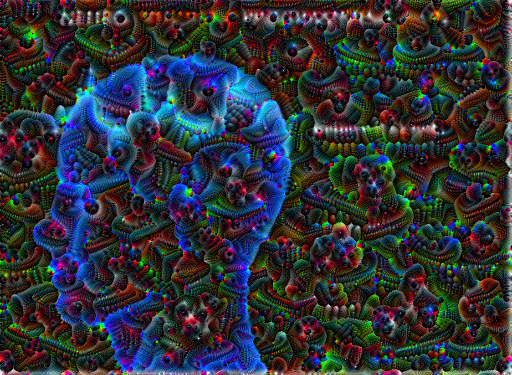

In [35]:
show_image(deprocess_inception_image(image_array))
image=array_to_img(image_array,True)
image.save("deep_dream_with_octave_tiling.jpg")

In [39]:
# try block to handle exception 
try: 
	# take path of image as a input 
	path = 'deep_dream_with_octave_tiling.jpg'
	
	# taking encryption key as input 
	key = int(input('Enter Key for encryption of Image : ')) 
	
	# print path of image file and encryption key that 
	# we are using 
	print('The path of file : ', path) 
	print('Key for encryption : ', key) 
	
	# open file for reading purpose 
	fin = open(path, 'rb') 
	
	# storing image data in variable "image" 
	image = fin.read() 
	fin.close() 
	
	# converting image into byte array to 
	# perform encryption easily on numeric data 
	image = bytearray(image) 

	# performing XOR operation on each value of bytearray 
	for index, values in enumerate(image): 
		image[index] = values ^ key 

	# opening file for writting purpose 
	fin = open(path, 'wb') 
	
	# writing encrypted data in image 
	fin.write(image) 
	fin.close() 
	print('Encryption Done...') 

	
except Exception: 
	print('Error caught : ', Exception.__name__) 


Enter Key for encryption of Image : 88
The path of file :  deep_dream_with_octave_tiling.jpg
Key for encryption :  88
Encryption Done...


In [40]:
# try block to handle the exception 
try: 
    # take path of image as a input 
    path = 'deep_dream_with_octave_tiling.jpg' 
      
    # taking decryption key as input 
    key = int(input('Enter Key for encryption of Image : ')) 
      
    # print path of image file and decryption key that we are using 
    print('The path of file : ', path) 
    print('Note : Encryption key and Decryption key must be same.') 
    print('Key for Decryption : ', key) 
      
    # open file for reading purpose 
    fin = open(path, 'rb') 
      
    # storing image data in variable "image" 
    image = fin.read() 
    fin.close() 
      
    # converting image into byte array to perform decryption easily on numeric data 
    image = bytearray(image) 
  
    # performing XOR operation on each value of bytearray 
    for index, values in enumerate(image): 
        image[index] = values ^ key 
  
    # opening file for writting purpose 
    fin = open(path, 'wb') 
      
    # writing decryption data in image 
    fin.write(image) 
    fin.close() 
    print('Decryption Done...') 
  
  
except Exception: 
    print('Error caught : ', Exception.__name__)

Enter Key for encryption of Image : 88
The path of file :  deep_dream_with_octave_tiling.jpg
Note : Encryption key and Decryption key must be same.
Key for Decryption :  88
Decryption Done...
